In [16]:
#!pip install -U dhlab
import os 
import datetime as dt
import pandas as pd

import dhlab as dh
from sentiment import load_corpus_from_file, compute_sentiment_analysis


# Sentimentanalyse i aviskorpus 

1. [Hent inn korpus](#korpusdefinisjon)
2. [Score sentiment for forekomster av et ord](#sentimentscore) 
3. [Lagre resultater i CSV-fil](#lagre-data)

## Korpusdefinisjon

**Fyll inn filsti** til lokal csv- eller excel-fil med korpusdefinisjon:


In [2]:
# INPUT KREVES
file_path = "FYLL INN"

Eventuelt **definer et korpus**  direkte med parametere. 

**Valgfritt:** Sett `save_to_file=True` hvis du vil lagre resulterende korpus til en ny, datostemplet CSV-fil

In [20]:
# INPUT KREVES
word = "biblioteket"
city="Kristiansand"
from_year=2000
to_year=2022
number_of_docs=10000

save_to_file=True

In [21]:
# korpusdefinisjonen tas vare på i corpus-variabelen som et dhlab.Corpus-objekt

if os.path.exists(file_path):
    corpus = load_corpus_from_file(file_path)

    print("Lastet corpus fra fil: ", file_path)
else:
    corpus = dh.Corpus(
        doctype="digavis", 
        fulltext=word, 
        freetext=f"city: {city}",
        from_year=from_year,
        to_year = to_year,
        limit=number_of_docs
    )

    print("Lastet corpus fra parametere: ")
    print(f"Aviser, utgitt mellom {from_year} og {to_year} i {city}, der ordet \"{word}\" forekommer.")

print(f"corpus består av {corpus.size} utgivelser")


Lastet corpus fra parametere: 
Aviser, utgitt mellom 2000 og 2022 i Kristiansand, der ordet "biblioteket" forekommer.
corpus består av 3441 utgivelser


In [22]:
if save_to_file:
    new_file_path = f"corpus_avis_{corpus.frame.year.min()}_{corpus.frame.year.max()}_{city}_{word}_created{dt.date.today()}.csv"
    corpus.to_csv(new_file_path)

## Sentimentscore

Kontekstene der nøkkelordet forekommer hentes ut fra korpuset, og vi beregner er sentimentscore på hvert tekstutdrag.

Det er en enkel analyse, med positive og negative ordlister: Vi regner ut differansen mellom summene av positive og negative ord i konteksten.

In [9]:
# Beregn en sentimentscore til kontekstene der nøkkelordet forekommer.
result = compute_sentiment_analysis(corpus, word)

In [12]:
result

,dhlabid,urn,title,city,timestamp,year,doctype,word,count,positive,negative,sentimentscore
0,200272007,URN:NBN:no-nb_digavis_budstikkasoegne_null_nul...,budstikkasoegne,Kristiansand,20080109,2008,digavis,biblioteket,4,10,1,9
1,200272008,URN:NBN:no-nb_digavis_budstikkasoegne_null_nul...,budstikkasoegne,Kristiansand,20080116,2008,digavis,biblioteket,2,2,2,0
2,200272009,URN:NBN:no-nb_digavis_budstikkasoegne_null_nul...,budstikkasoegne,Kristiansand,20080123,2008,digavis,biblioteket,1,0,1,-1
3,200272010,URN:NBN:no-nb_digavis_budstikkasoegne_null_nul...,budstikkasoegne,Kristiansand,20080130,2008,digavis,biblioteket,2,0,3,-3
4,200272011,URN:NBN:no-nb_digavis_budstikkasoegne_null_nul...,budstikkasoegne,Kristiansand,20080206,2008,digavis,biblioteket,2,0,2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...
2487,200486853,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20190411,2019,digavis,biblioteket,1,0,2,-2
2488,200486858,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20190417,2019,digavis,biblioteket,2,1,0,1
2489,200486862,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20190426,2019,digavis,biblioteket,3,2,4,-2
2490,200486868,URN:NBN:no-nb_digavis_faedrelandsvennen_null_n...,faedrelandsvennen,Kristiansand,20200221,2020,digavis,biblioteket,3,3,5,-2



## Visualiser resultatet


<AxesSubplot: xlabel='year'>

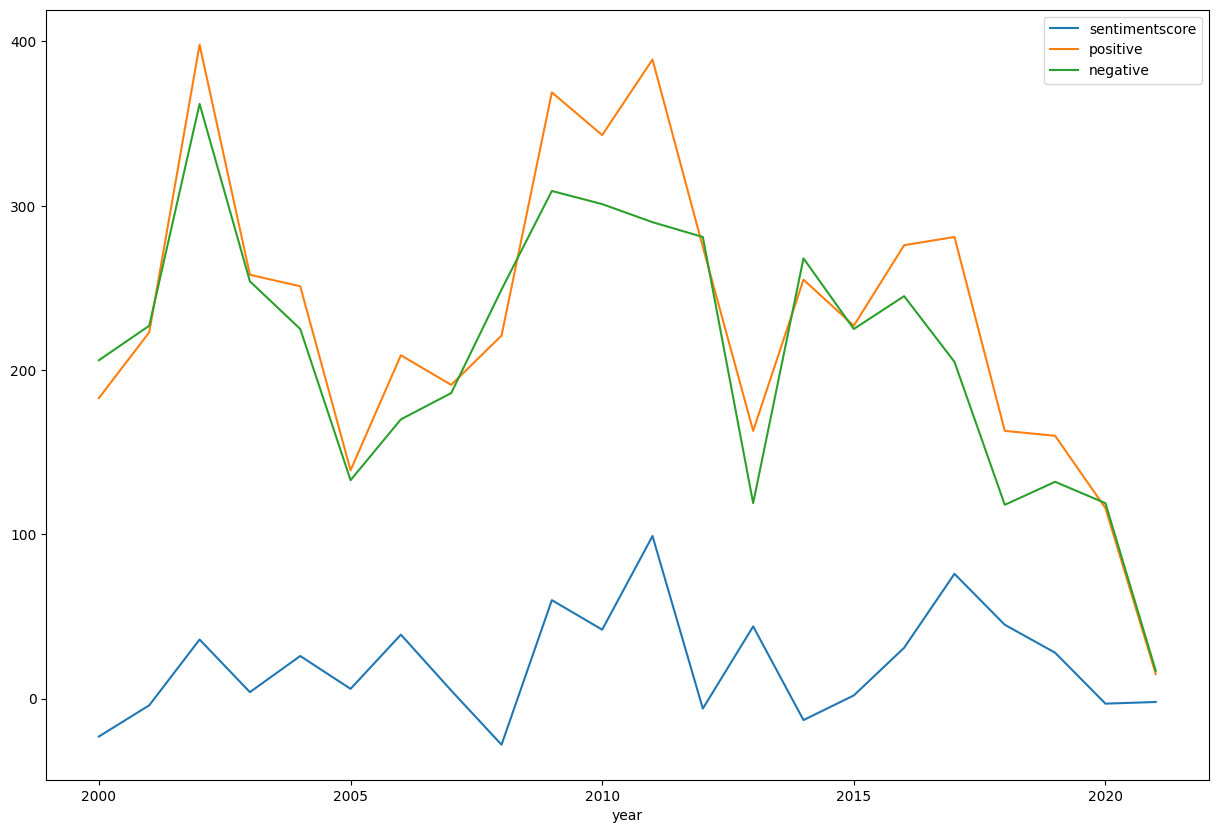

In [50]:
r = result[["year","positive", "negative", "sentimentscore"]]
rgroup = r.groupby("year")[["sentimentscore", "positive", "negative"]].sum() 
rgroup.plot()

##  Lagre data 

**Skriv utdata** til en CSV-fil på ditt lokale filsystem.

Kolonner:
-  dhlab-ID (digitalt tekstobjekt)
-  URN (digitalt bilde av tekstdokument)
-  avistittel
-  sted
-  dato
-  nøkkelord
-  ordfrekvens
-  postiv score
-  negativ score
-  sum sentimentscore


In [ ]:
outputfile = f"sentimentanalyse_aviskorpus_{from_year}-{to_year}_{dt.date.today()}.csv"
result.to_csv(outputfile)